### Decoding animal's behaviors from neural data

__By Neuromatch Academy 2023 Deep Learning Agustinia-Tsam project team 2__

__Project team:__ Ke Chen, Mohammad Samavat, Raymond Shpeley, Dev laxman Subramanian, Arjun Verma

We use the Steinmetz dataset to decode animal behaviours over a range of neural network models to determine which models best correspond to mouse behaviours.

This notebook is coded by Ke Chen.

___


##### Imports

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
#%%
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset

from tqdm.auto import tqdm
from IPython.display import display


Useful function to group data according to brain regions

In [2]:
def data_with_each_brain(dat, regions, brain_groups):
    data = {}
    data['all'] = dat['spks']
    nareas = 7  # only the top 7 regions are in this particular mouse
    NN = len(dat['brain_area'])  # number of neurons
    barea = nareas * np.ones(NN, )  # last one is "other"
    for j in range(nareas):
        barea[np.isin(dat['brain_area'], brain_groups[j])] = j  # assign a number to each region

    counter = 0
    for region in regions:
        data[region] = dat['spks'][barea == counter]
        counter += 1

    for key in data:
        print(f"There are {len(data[key])} neurons recorded in {key}  region\n")
    
    for key in data:
        plt.figure(figsize = (10, 6))
        plt.imshow(data[key][:, 0, :], cmap='gray_r', vmax = 3, vmin=0, aspect='auto')
        plt.xlabel('Time (ms)')
        plt.ylabel('Cell #')
        plt.colorbar(orientation='vertical', label='# Spikes in 0.01 s time bin')
        plt.title(f'Example trial in {key}')
        plt.show()
    return data

def shuffle_and_split_data(X, y, seed):
  """
  Helper function to shuffle and split data

  Args:
    X: torch.tensor
      Input data
    y: torch.tensor
      Corresponding target variables
    seed: int
      Set seed for reproducibility

  Returns:
    X_test: torch.tensor
      Test data [20% of X]
    y_test: torch.tensor
      Labels corresponding to above mentioned test data
    X_train: torch.tensor
      Train data [80% of X]
    y_train: torch.tensor
      Labels corresponding to above mentioned train data
  """
  # Set seed for reproducibility
  torch.manual_seed(seed)
  # Number of samples
  N = X.shape[1]
  # Shuffle data
  shuffled_indices = torch.randperm(N)   # Get indices to shuffle data, could use torch.randperm
  X = X[:,shuffled_indices]
  y = y[shuffled_indices]

  # Split data into train/test
  test_size = int(0.2 * N)    # Assign test datset size using 20% of samples
  X_test = X[:,:test_size]
  y_test = y[:test_size]
  X_train = X[:,test_size:]
  y_train = y[test_size:]

  return X_test, y_test, X_train, y_train

def l1_reg(model):
  """
  This function calculates the l1 norm of the all the tensors in the model

  Args:
    model: nn.module
      Neural network instance

  Returns:
    l1: float
      L1 norm of the all the tensors in the model
  """
  l1 = 0.0
  for param in model.parameters():
    l1 +=  torch.abs(param).sum()

  return l1

def l2_reg(model):
  """
  This function calculates the l2 norm of the all the tensors in the model

  Args:
    model: nn.module
      Neural network instance

  Returns:
    l2: float
      L2 norm of the all the tensors in the model
  """
  l2 = 0.0

  for param in model.parameters():
    l2 += torch.sum(torch.abs(param)**2)

  return l2

Build a Multi-layer Perceptron

In [3]:
# Functions to Build MLP

class Net(nn.Module):
  """
  Simulate MLP Network
  """

  def __init__(self, actv, input_feature_num, hidden_unit_nums, output_feature_num):
    """
    Initialize MLP Network parameters

    Args:
      actv: string
        Activation function
      input_feature_num: int
        Number of input features
      hidden_unit_nums: int
        Number of units in the hidden layer
      output_feature_num: int
        Number of output features

    Returns:
      Nothing
    """
    super(Net, self).__init__()
    self.input_feature_num = input_feature_num # Save the input size for reshapinng later
    self.mlp = nn.Sequential() # Initialize layers of MLP

    in_num = input_feature_num # Initialize the temporary input feature to each layer
    
    for i in range(len(hidden_unit_nums)): # Loop over layers and create each one
      out_num = hidden_unit_nums[i] # Assign the current layer hidden unit from list
      if out_num == 0 : # No hidden layer
        print('Hidden Units set to 0. There is no hidden layer')
        break
      layer = nn.Linear(in_num, out_num) # Use nn.Linear to define the layer
      in_num = out_num # Assign next layer input using current layer output
      self.mlp.add_module(f"Linear_{i}", layer) # Append layer to the model with a name
      actv_layer = eval(f"nn.{actv}") # Assign activation function (eval allows us to instantiate object from string)
      self.mlp.add_module(f"Activation_{i}", actv_layer) # Append activation to the model with a name

    out_layer = nn.Linear(in_num, output_feature_num) # Create final layer
    self.mlp.add_module('Output_Linear', out_layer) # Append the final layer

  def forward(self, x):
    """
    Simulate forward pass of MLP Network

    Args:
      x: torch.tensor
        Input data

    Returns:
      logits: Instance of MLP
        Forward pass of MLP
    """
    # Reshape inputs to (batch_size, input_feature_num)
    # Just in case the input vector is not 2D, like an image!
    x = x.view(-1, self.input_feature_num)

    logits = self.mlp(x) # forward pass of MLP
    output = F.log_softmax(logits)
    return output




def train(args, model, train_loader, optimizer, epoch,
          reg_function1=None, reg_function2=None, criterion=F.nll_loss):
  """
  Trains the current input model using the data
  from Train_loader and Updates parameters for a single pass

  Args:
    args: dictionary
      Dictionary with epochs: 200, lr: 5e-3, momentum: 0.9, device: DEVICE
    model: nn.module
      Neural network instance
    train_loader: torch.loader
      Input dataset
    optimizer: function
      Optimizer
    reg_function1: function
      Regularisation function [default: None]
    reg_function2: function
      Regularisation function [default: None]
    criterion: function
      Specifies loss function [default: nll_loss]

  Returns:
    model: nn.module
      Neural network instance post training
  """
  device = args['device']
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device).float(), target.to(device).long()
    optimizer.zero_grad()
    output = model(data)
    # L1 regularization
    if reg_function2 is None and reg_function1 is not None:
      loss = criterion(output, target) + args['lambda1']*reg_function1(model)
    # L2 regularization
    elif reg_function1 is None and reg_function2 is not None:
      loss = criterion(output, target) + args['lambda2']*reg_function2(model)
    # No regularization
    elif reg_function1 is None and reg_function2 is None:
      loss = criterion(output, target)
    # Both L1 and L2 regularizations
    else:
      loss = criterion(output, target) + args['lambda1']*reg_function1(model) + args['lambda2']*reg_function2(model)
    loss.backward()
    optimizer.step()

  return model


def test(model, test_loader, loader='Test', criterion=F.nll_loss,
         device='cpu'):
  """
  Tests the current model

  Args:
    model: nn.module
      Neural network instance
    device: string
      GPU/CUDA if available, CPU otherwise
    test_loader: torch.loader
      Test dataset
    criterion: function
      Specifies loss function [default: nll_loss]

  Returns:
    test_loss: float
      Test loss
  """
  model.eval()
  test_loss = 0
  correct = 0
  total = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device).float(), target.to(device).long()
      output = model(data)
      test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
      pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      total += target.size(0)

  test_loss /= len(test_loader.dataset)
  test_acc = correct/total
  # return 100. * correct / len(test_loader.dataset)
  return test_acc


def main(args, model, train_loader, val_loader,
         reg_function1=None, reg_function2=None, criterion=F.nll_loss):
  """
  Trains the model with train_loader and
  tests the learned model using val_loader

  Args:
    args: dictionary
      Dictionary with epochs: 200, lr: 5e-3, momentum: 0.9, device: DEVICE
    model: nn.module
      Neural network instance
    train_loader: torch.loader
      Train dataset
    val_loader: torch.loader
      Validation set
    reg_function1: function
      Regularisation function [default: None]
    reg_function2: function
      Regularisation function [default: None]

  Returns:
    val_acc_list: list
      Log of validation accuracy
    train_acc_list: list
      Log of training accuracy
    param_norm_list: list
      Log of frobenius norm
    trained_model: nn.module
      Trained model/model post training
  """
  device = args['device']

  model = model.to(device)
  optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

  val_acc_list, train_acc_list,param_norm_list = [], [], []
  for epoch in tqdm(range(args['epochs'])):
    trained_model = train(args, model, train_loader, optimizer, epoch,
                          reg_function1=reg_function1,
                          reg_function2=reg_function2)
    train_acc = test(trained_model, train_loader, loader='Train', device=device)
    val_acc = test(trained_model, val_loader, loader='Val', device=device)
    param_norm = calculate_frobenius_norm(trained_model)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    param_norm_list.append(param_norm)

  return val_acc_list, train_acc_list, param_norm_list, model


def calculate_frobenius_norm(model):
    """
    Function to calculate frobenius norm

    Args:
      model: nn.module
        Neural network instance

    Returns:
      norm: float
        Frobenius norm
    """
    norm = 0.0
    # Sum the square of all parameters
    for name,param in model.named_parameters():
        norm += torch.norm(param).data**2
    # Return a square root of the sum of squares of all the parameters
    return norm**0.5


def early_stopping_main(args, model, train_loader, val_loader, 
                        reg_function1=None, reg_function2=None, criterion=F.nll_loss):
  """
  Function to simulate early stopping

  Args:
    args: dictionary
      Dictionary with epochs: 200, lr: 5e-3, momentum: 0.9, device: DEVICE
    model: nn.module
      Neural network instance
    train_loader: torch.loader
      Train dataset
    val_loader: torch.loader
      Validation set

  Returns:
    val_acc_list: list
      Val accuracy log until early stop point
    train_acc_list: list
      Training accuracy log until early stop point
    best_model: nn.module
      Model performing best with early stopping
    best_epoch: int
      Epoch at which early stopping occurs
  """
  device = args['device']

  model = model.to(device)
  optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

  best_acc  = 0.0
  best_epoch = 0

  # Number of successive epochs that you want to wait before stopping training process
  patience = 20

  # Keps track of number of epochs during which the val_acc was less than best_acc
  wait = 0

  val_acc_list, train_acc_list = [], []
  for epoch in tqdm(range(args['epochs'])):
    trained_model = train(args, model, train_loader, optimizer, epoch,
                          reg_function1=reg_function1,
                          reg_function2=reg_function2)
    train_acc = test(trained_model, train_loader, loader='Train', device=device)
    val_acc = test(trained_model, val_loader, loader='Val', device=device)
    if (val_acc > best_acc):
      best_acc = val_acc
      best_epoch = epoch
      best_model = copy.deepcopy(trained_model)
      wait = 0
    else:
      wait += 1
    if (wait > patience):
      print(f'Early stopped on epoch: {epoch}')
      break
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

  return val_acc_list, train_acc_list, best_model, best_epoch

##### Set device to GPU or CPU

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

##### Set random seed

In [5]:
# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 16)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')
  return seed


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [6]:
SEED = 2021
set_seed(seed=SEED)

Random seed 2021 has been set.


2021

##### Data retrieval

In [7]:
# store the dataset files in the datasets folder
import os, requests

fname = []
ds = "../datasets"

for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile("/".join([ds, fname[j]])):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open("/".join([ds, fname[j]]), "wb") as fid:
          fid.write(r.content)

In [8]:
# @title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load("/".join([ds, 'steinmetz_part%d.npz'%j]),
                              allow_pickle=True)['dat']))

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned).

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded.
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron.
* `dat['ccf_axes']`: axes names for the Allen CCF.
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus.
* `dat['gocue']`: when the go cue sound was played.
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response.
* `dat['feedback_time']`: when feedback was provided.
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`.
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera.
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons".
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses.
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time.
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: [https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406](https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406)

##### Make a plot of which brain areas are present in each dataset
Note that region 4 ("other ctx" are neurons that were not able to be classified). Region 4 does not correspond to brain_group 4, which are all cortical neurons outside of the visual cortex.

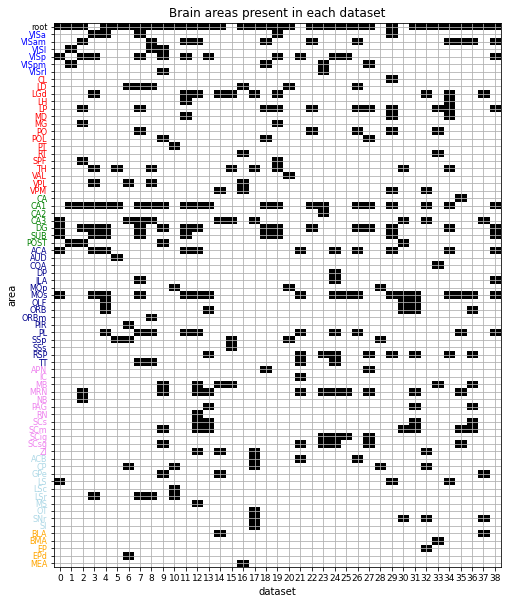

In [9]:
regions = ["vis_ctx", "thal", "hipp", "other_ctx", "midbrain", "basal_ganglia", "cortical_subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"],  # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                ]

# Assign each area an index
area_to_index = dict(root=0)
counter = 1
for group in brain_groups:
    for area in group:
        area_to_index[area] = counter
        counter += 1

# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((counter, len(alldat)), dtype=bool)
for j, d in enumerate(alldat):
    for area in np.unique(d['brain_area']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in brain_groups:
  yticklabels.extend(group)
plt.yticks(np.arange(counter), yticklabels, fontsize=8)
plt.xticks(np.arange(len(alldat)), fontsize=9)

# Color the tick labels by region
ytickobjs = plt.gca().get_yticklabels()
ytickobjs[0].set_color("black")
counter = 1
for group, color in zip(brain_groups, region_colors):
  for area in group:
    ytickobjs[counter].set_color(color)
    counter += 1

plt.title("Brain areas present in each dataset")
plt.grid(True)
plt.show()

##### Basic plots of population average


dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


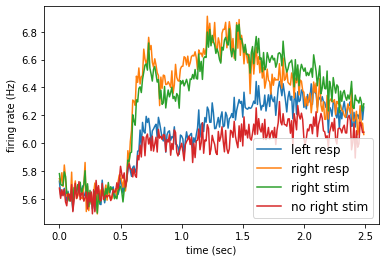

In [10]:
# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
dat = alldat[12]
print(dat.keys())

dt = dat['bin_size']  # binning at 10 ms
NT = dat['spks'].shape[-1]

ax = plt.subplot(1, 1, 1)
response = dat['response']  # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right']  # 0 - low - high
vis_left = dat['contrast_left']  # 0 - low - high
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, response >= 0].mean(axis=(0, 1)))  # left responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, response < 0].mean(axis=(0, 1)))  # right responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, vis_right > 0].mean(axis=(0, 1)))  # stimulus on the right
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, vis_right == 0].mean(axis=(0, 1)))  # no stimulus on the right

plt.legend(['left resp', 'right resp', 'right stim', 'no right stim'], fontsize=12)
ax.set(xlabel='time (sec)', ylabel='firing rate (Hz)')
plt.show()

##### Visulize the data from one trial

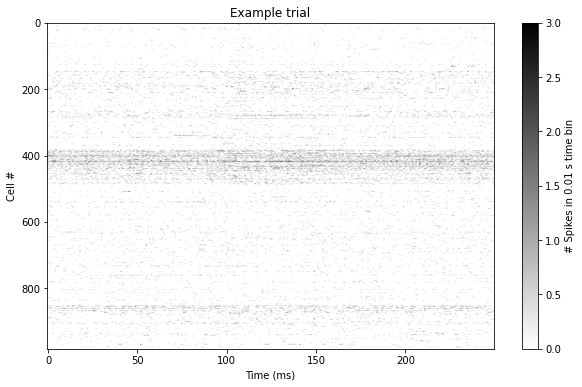

In [11]:
plt.figure(figsize = (10, 6))
plt.imshow(dat['spks'][:, 0, :], cmap='gray_r', vmax = 3, vmin=0, aspect='auto')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.colorbar(orientation='vertical', label='# Spikes in 0.01 s time bin')
plt.title('Example trial')
plt.show()

Prepare data for Deep Learning

C:\Users\KeChen\AppData\Local\Temp/ipykernel_27640/508139110.py:11: RuntimeWarning: Mean of empty slice.
  plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left == 0, vis_right > 0)].mean(axis=(0, 1)))
c:\Users\KeChen\anaconda3\envs\video\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\KeChen\AppData\Local\Temp/ipykernel_27640/508139110.py:12: RuntimeWarning: Mean of empty slice.
  plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left > 0, vis_right == 0)].mean(axis=(0, 1)))
C:\Users\KeChen\AppData\Local\Temp/ipykernel_27640/508139110.py:13: RuntimeWarning: Mean of empty slice.
  plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left == 0, vis_right == 0)].mean(axis=(0, 1)))
C:\Users\KeChen\AppData\Local\Temp/ipykernel_27640/508139110.py:14: RuntimeWarning: Mean of empty slice.
  plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left > 0, vis_right > 0)].mea

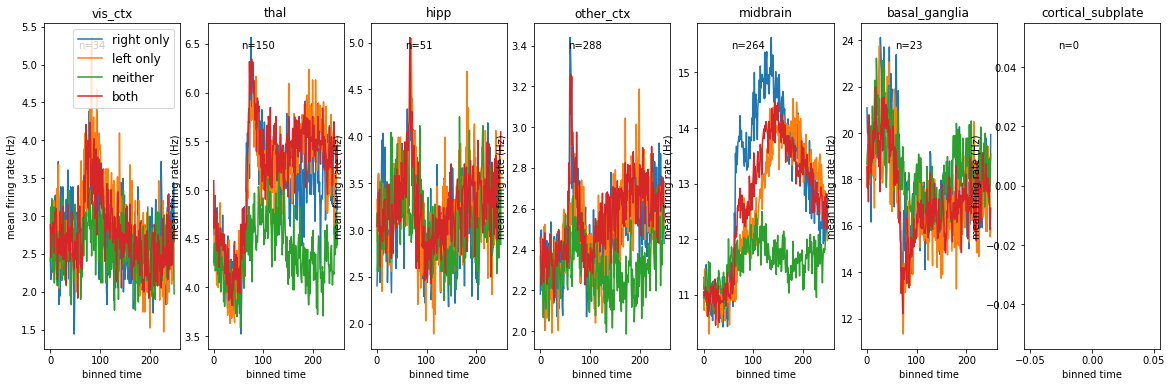

In [12]:
nareas = 7  # only the top 7 regions are in this particular mouse
NN = len(dat['brain_area'])  # number of neurons
barea = nareas * np.ones(NN, )  # last one is "other"
for j in range(nareas):
  barea[np.isin(dat['brain_area'], brain_groups[j])] = j  # assign a number to each region

plt.figure(figsize = (20, 6))
for j in range(nareas):
  ax = plt.subplot(1, nareas, j + 1)

  plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left == 0, vis_right > 0)].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left > 0, vis_right == 0)].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left == 0, vis_right == 0)].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left > 0, vis_right > 0)].mean(axis=(0, 1)))
  plt.text(.25, .92, 'n=%d'%np.sum(barea == j), transform=ax.transAxes)

  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=12)
  ax.set(xlabel='binned time', ylabel='mean firing rate (Hz)', title=regions[j])
plt.show()


In [13]:
data = {}
data['all'] = dat['spks']
counter = 0
for region in regions:
    data[region] = dat['spks'][barea == counter]
    counter += 1

for key in data:
    print(f"There are {len(data[key])} neurons recorded in {key}  region\n")


There are 983 neurons recorded in all  region

There are 34 neurons recorded in vis_ctx  region

There are 150 neurons recorded in thal  region

There are 51 neurons recorded in hipp  region

There are 288 neurons recorded in other_ctx  region

There are 264 neurons recorded in midbrain  region

There are 23 neurons recorded in basal_ganglia  region

There are 0 neurons recorded in cortical_subplate  region

There are 173 neurons recorded in other  region



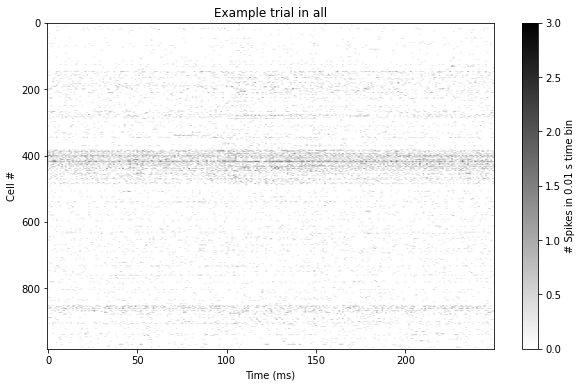

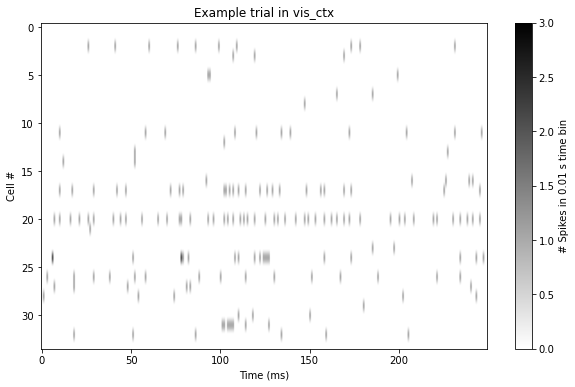

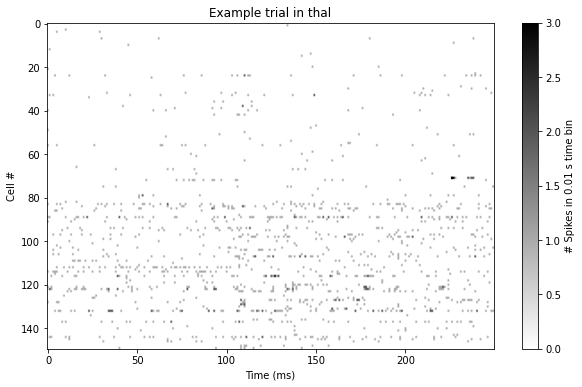

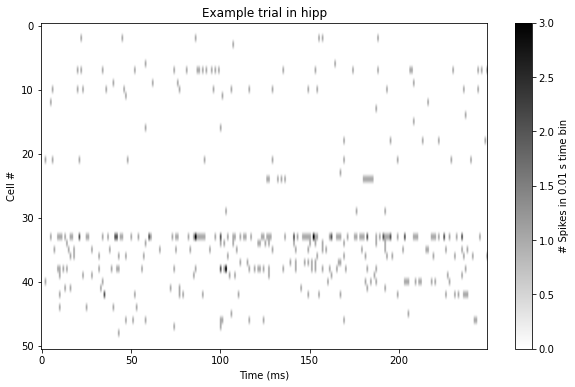

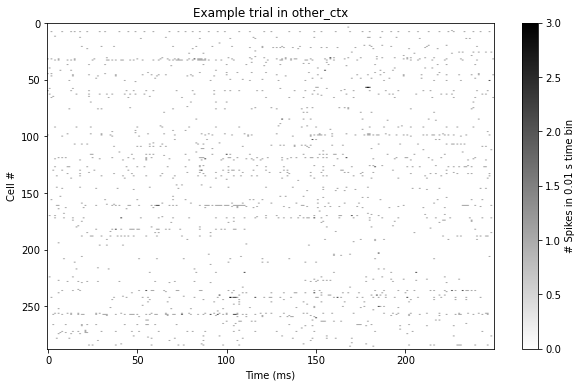

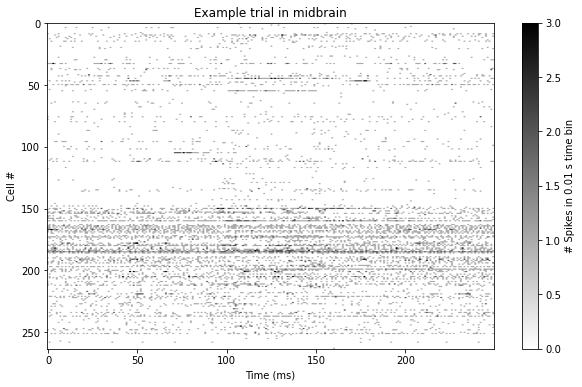

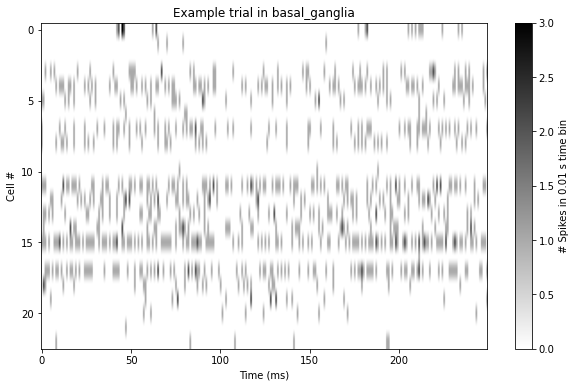

C:\Users\KeChen\AppData\Local\Temp/ipykernel_27640/3762215193.py:5: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(data[key][:, 0, :], cmap='gray_r', vmax = 3, vmin=0, aspect='auto')


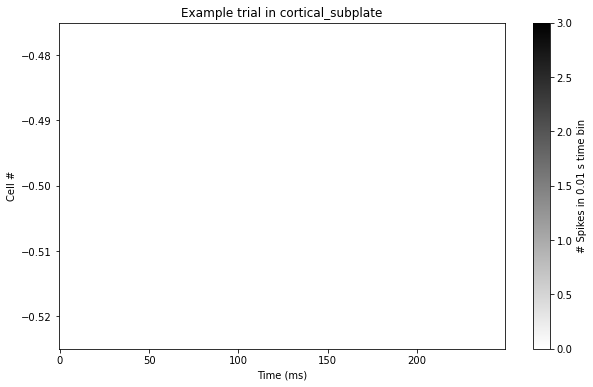

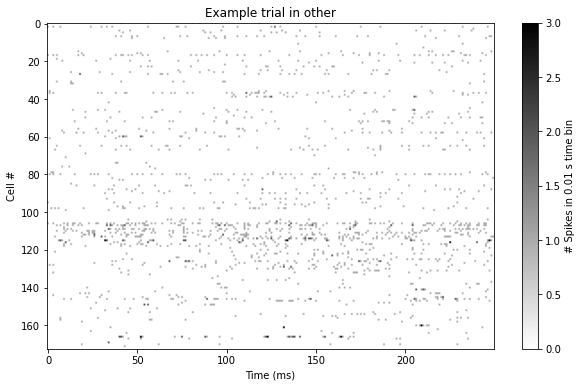

In [14]:
# data is a dictionary that contains neural data for different brain regions
# Visulize the data from one trial
for key in data:
    plt.figure(figsize = (10, 6))
    plt.imshow(data[key][:, 0, :], cmap='gray_r', vmax = 3, vmin=0, aspect='auto')
    plt.xlabel('Time (ms)')
    plt.ylabel('Cell #')
    plt.colorbar(orientation='vertical', label='# Spikes in 0.01 s time bin')
    plt.title(f'Example trial in {key}')
    plt.show()



There are 698 neurons recorded in all  region

There are 145 neurons recorded in vis_ctx  region

There are 155 neurons recorded in thal  region

There are 220 neurons recorded in hipp  region

There are 78 neurons recorded in other_ctx  region

There are 0 neurons recorded in midbrain  region

There are 0 neurons recorded in basal_ganglia  region

There are 0 neurons recorded in cortical_subplate  region

There are 100 neurons recorded in other  region



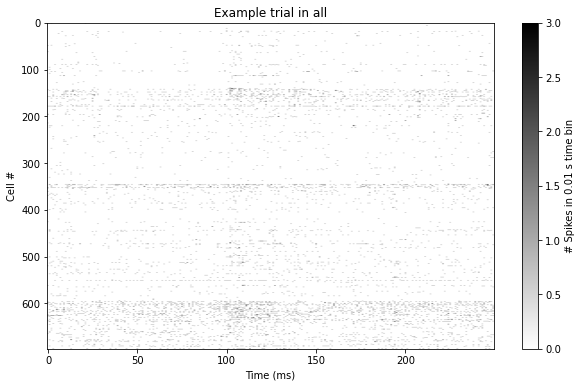

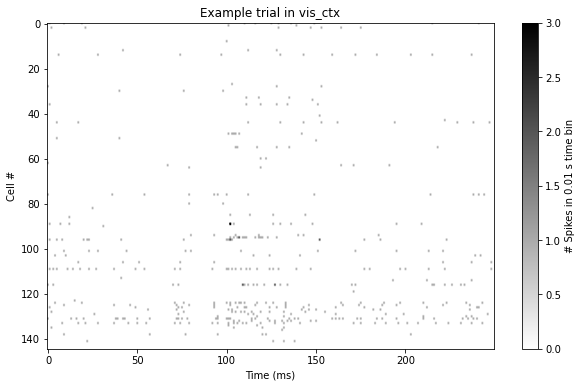

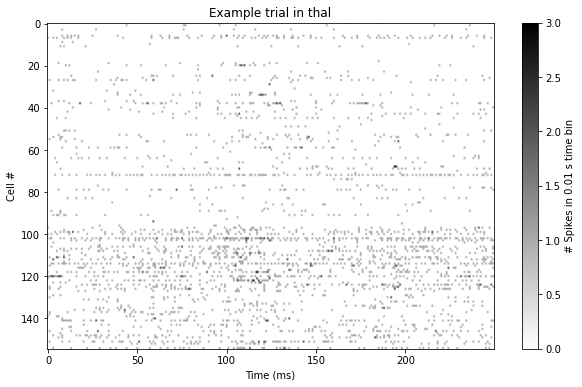

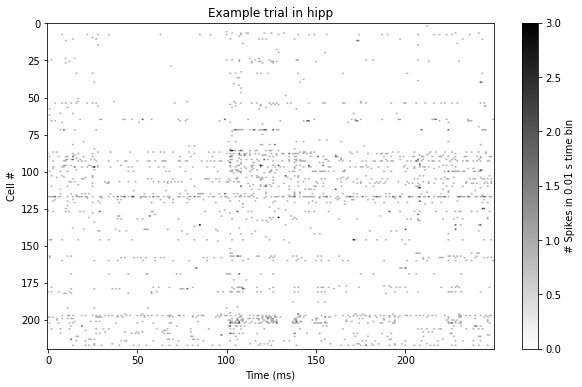

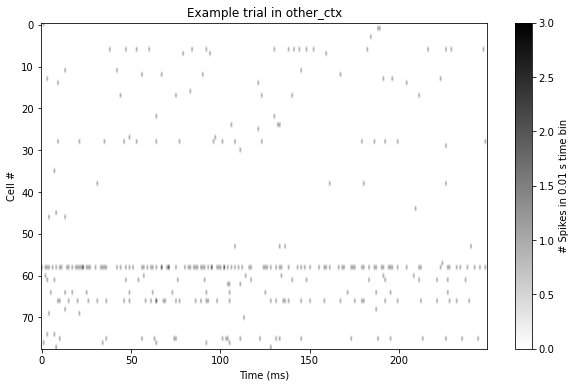

C:\Users\KeChen\AppData\Local\Temp/ipykernel_27640/3751611018.py:20: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(data[key][:, 0, :], cmap='gray_r', vmax = 3, vmin=0, aspect='auto')


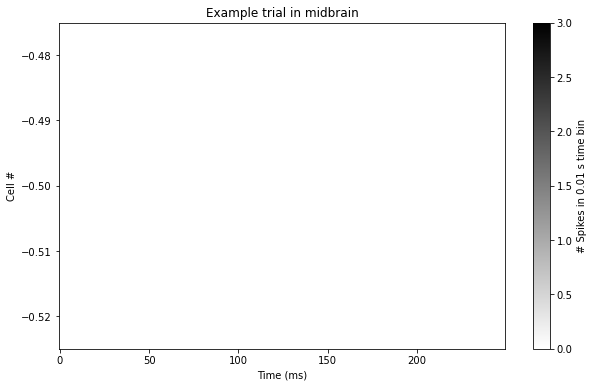

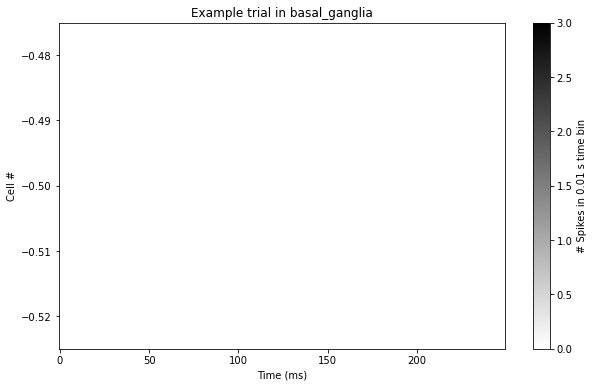

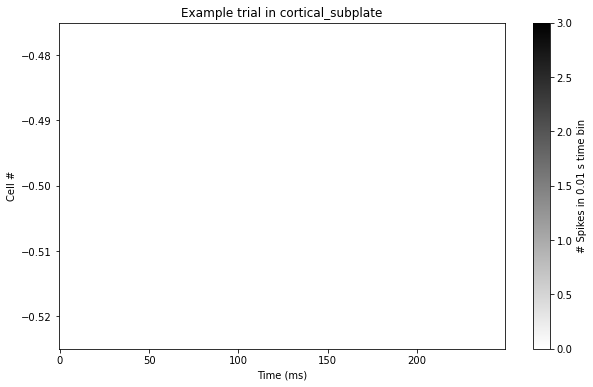

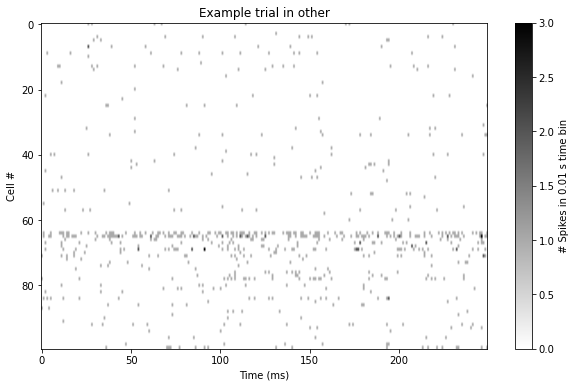

In [15]:
dat = alldat[11] # you can try 11 or 12 for different recording sessions: 11 has more neurons in vis ctx, thal, and hipp; and 12 has more in brainstem, thal, and other ctx
data = data_with_each_brain(dat, regions, brain_groups)

## data for Deep Learing
X = data['all'] # input data, could be data['all'], data['vis_ctx'], data['thal'], data['hipp'], data['other_ctx'], data['midbrain'], data['basal_ganglia']
y = dat['response']# output data, could be Classification Problem: dat['response'], dat['feedback_type'],//////// Regression Problem: dat['response_time'], dat['pupil'], dat['wheel']

In [16]:
# Prepare data for MLP
# X = torch.from_numpy(dat['spks'])
X = torch.from_numpy(data['other_ctx'])
dat['response'][dat['response'] == -1] = 2 # targets can not be -1
y = torch.from_numpy(dat['response']) # responses is just one of multiple options for animals's behaivors,

# flatten the tensor
X_temp = torch.empty(X.shape[0] * X.shape[2], X.shape[1])
for i in range(X.shape[1]):
    X_temp[:,i] = X[:, i,:].flatten()





In [17]:
SEED = None
seedrd = set_seed(seed=SEED)
batch_size = 96
# Run the model multiple time to get the variation of the training/validation performance
N = 5 # traing the model N times
val_acc_unreg    = []
train_acc_unreg  = []
param_norm_unreg = []

for i in range(N):
    SEED = None
    seedrd = set_seed(seed=SEED)
    X_test, y_test, X_train, y_train = shuffle_and_split_data(X_temp, y, seed=seedrd)
    # DataLoader with random seed
    g_seed = torch.Generator()
    g_seed.manual_seed(seedrd)

    test_data = TensorDataset(X_test.T, y_test)
    test_loader = DataLoader(test_data, batch_size=batch_size,
                            shuffle=False, num_workers=0,
                            worker_init_fn=seed_worker,
                            generator=g_seed,
                            )
    train_data = TensorDataset(X_train.T, y_train)
    train_loader = DataLoader(train_data,
                            batch_size=batch_size,
                            drop_last=True,
                            shuffle=True,
                            worker_init_fn=seed_worker,
                            generator=g_seed,
                            )

    args = {
        'epochs': 50,
        'lr': 1e-3,
        'momentum': 0.99,
        'device': device,
        'lambda1': 0,
        'lambda2': 0
    }
    # Train the model
    # plt.figure()

    hidden_units = 0
    model = Net('ReLU()', X_train.shape[0], [hidden_units], 3).to(device)  # single hidden layer
    val_acc, train_acc, param_norm, _ = main(args,
                                                            model,
                                                            train_loader,
                                                            test_loader,
                                                            reg_function1 = l1_reg,
                                                            reg_function2 = l2_reg)
    val_acc_unreg += [val_acc]
    train_acc_unreg += [train_acc]
    print(f"Finish training the Model {i + 1}")
    



Random seed 25716 has been set.
Random seed 57457 has been set.
Hidden Units set to 0. There is no hidden layer


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\KeChen\AppData\Local\Temp/ipykernel_27640/4290504073.py:62: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(logits)


Finish training the Model 1
Random seed 42599 has been set.
Hidden Units set to 0. There is no hidden layer


  0%|          | 0/50 [00:00<?, ?it/s]

Finish training the Model 2
Random seed 2192 has been set.
Hidden Units set to 0. There is no hidden layer


  0%|          | 0/50 [00:00<?, ?it/s]

Finish training the Model 3
Random seed 61600 has been set.
Hidden Units set to 0. There is no hidden layer


  0%|          | 0/50 [00:00<?, ?it/s]

Finish training the Model 4
Random seed 1285 has been set.
Hidden Units set to 0. There is no hidden layer


  0%|          | 0/50 [00:00<?, ?it/s]

Finish training the Model 5


Maximum Validation Accuracy reached: 0.5
Maximum Validation Accuracy reached: 0.5294117647058824
Maximum Validation Accuracy reached: 0.5
Maximum Validation Accuracy reached: 0.5735294117647058
Maximum Validation Accuracy reached: 0.5588235294117647


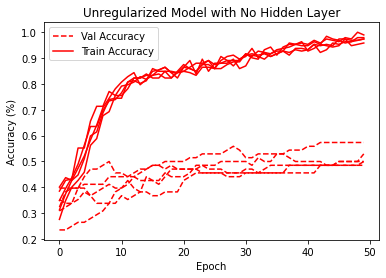

In [18]:
# Train and Test accuracy plot
plt.figure
for i in range(len(val_acc_unreg)):
    plt.plot(val_acc_unreg[i], label='Val Accuracy', c='red', ls='dashed')
    plt.plot(train_acc_unreg[i], label='Train Accuracy', c='red', ls='solid')
    # plt.axhline(y=max(val_acc_unreg), c='green', ls='dashed')
    plt.title('Unregularized Model with No Hidden Layer')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Epoch')
    if i ==0:
        plt.legend()
    print(f"Maximum Validation Accuracy reached: {max(val_acc_unreg[i])}")
plt.show()


In [19]:
# Train with regularization
SEED = None
seedrd = set_seed(seed=SEED)

# Run the model multiple time to get the variation of the training/validation performance
N = 5 # traing the model N times
val_acc_reg    = []
train_acc_reg  = []
param_norm_reg = []

for i in range(N):
    SEED = None
    seedrd = set_seed(seed=SEED)
    X_test, y_test, X_train, y_train = shuffle_and_split_data(X_temp, y, seed=seedrd)
    # DataLoader with random seed
    g_seed = torch.Generator()
    g_seed.manual_seed(seedrd)

    test_data = TensorDataset(X_test.T, y_test)
    test_loader = DataLoader(test_data, batch_size=batch_size,
                            shuffle=False, num_workers=0,
                            worker_init_fn=seed_worker,
                            generator=g_seed,
                            )
    train_data = TensorDataset(X_train.T, y_train)
    train_loader = DataLoader(train_data,
                            batch_size=batch_size,
                            drop_last=True,
                            shuffle=True,
                            worker_init_fn=seed_worker,
                            generator=g_seed,
                            )

    args = {
        'epochs': 50,
        'lr': 1e-3,
        'momentum': 0.99,
        'device': device,
        'lambda1': 0.005,
        'lambda2': 0.005
    }
    # Train the model
    # plt.figure()

    hidden_units = 0
    model = Net('ReLU()', X_train.shape[0], [hidden_units], 3).to(device)  # single hidden layer
    val_acc, train_acc, param_norm, _ = early_stopping_main(args,
                                                            model,
                                                            train_loader,
                                                            test_loader,
                                                            reg_function1 = l1_reg,
                                                            reg_function2 = l2_reg)
    val_acc_reg += [val_acc]
    train_acc_reg += [train_acc]
    print(f"Finish training the Model {i + 1}")
    



Random seed 25070 has been set.
Random seed 22954 has been set.
Hidden Units set to 0. There is no hidden layer


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\KeChen\AppData\Local\Temp/ipykernel_27640/4290504073.py:62: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(logits)


Finish training the Model 1
Random seed 7327 has been set.
Hidden Units set to 0. There is no hidden layer


  0%|          | 0/50 [00:00<?, ?it/s]

Early stopped on epoch: 45
Finish training the Model 2
Random seed 3631 has been set.
Hidden Units set to 0. There is no hidden layer


  0%|          | 0/50 [00:00<?, ?it/s]

Early stopped on epoch: 43
Finish training the Model 3
Random seed 47917 has been set.
Hidden Units set to 0. There is no hidden layer


  0%|          | 0/50 [00:00<?, ?it/s]

Finish training the Model 4
Random seed 35044 has been set.
Hidden Units set to 0. There is no hidden layer


  0%|          | 0/50 [00:00<?, ?it/s]

Early stopped on epoch: 39
Finish training the Model 5


Maximum Validation Accuracy reached: 0.5441176470588235
Maximum Validation Accuracy reached: 0.5
Maximum Validation Accuracy reached: 0.5441176470588235
Maximum Validation Accuracy reached: 0.6029411764705882
Maximum Validation Accuracy reached: 0.5294117647058824


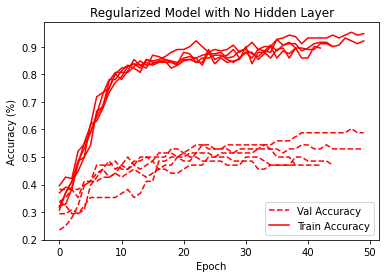

In [20]:
plt.figure
for i in range(len(val_acc_reg)):
    plt.plot(val_acc_reg[i], label='Val Accuracy', c='red', ls='dashed')
    plt.plot(train_acc_reg[i], label='Train Accuracy', c='red', ls='solid')
    # plt.axhline(y=max(val_acc_unreg), c='green', ls='dashed')
    plt.title('Regularized Model with No Hidden Layer')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Epoch')
    if i ==0:
        plt.legend()
    print(f"Maximum Validation Accuracy reached: {max(val_acc_reg[i])}")        
plt.show()


In [21]:
# Train with regularization
SEED = None
seedrd = set_seed(seed=SEED)

# Run the model multiple time to get the variation of the training/validation performance
N = 5 # traing the model N times
val_acc_reg10    = []
train_acc_reg10  = []
param_norm_reg10 = []

for i in range(N):
    SEED = None
    seedrd = set_seed(seed=SEED)
    X_test, y_test, X_train, y_train = shuffle_and_split_data(X_temp, y, seed=seedrd)
    # DataLoader with random seed
    g_seed = torch.Generator()
    g_seed.manual_seed(seedrd)

    test_data = TensorDataset(X_test.T, y_test)
    test_loader = DataLoader(test_data, batch_size=batch_size,
                            shuffle=False, num_workers=0,
                            worker_init_fn=seed_worker,
                            generator=g_seed,
                            )
    train_data = TensorDataset(X_train.T, y_train)
    train_loader = DataLoader(train_data,
                            batch_size=batch_size,
                            drop_last=True,
                            shuffle=True,
                            worker_init_fn=seed_worker,
                            generator=g_seed,
                            )

    args = {
        'epochs': 50,
        'lr': 1e-3,
        'momentum': 0.99,
        'device': device,
        'lambda1': 0.005,
        'lambda2': 0.005
    }
    # Train the model
    # plt.figure()

    hidden_units = 10
    model = Net('ReLU()', X_train.shape[0], [hidden_units], 3).to(device)  # single hidden layer
    val_acc, train_acc, param_norm, _ = early_stopping_main(args,
                                                            model,
                                                            train_loader,
                                                            test_loader,
                                                            reg_function1 = l1_reg,
                                                            reg_function2 = l2_reg)
    val_acc_reg10 += [val_acc]
    train_acc_reg10 += [train_acc]
    print(f"Finish training the Model {i + 1}")
    



Random seed 30805 has been set.
Random seed 2073 has been set.


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\KeChen\AppData\Local\Temp/ipykernel_27640/4290504073.py:62: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(logits)


Early stopped on epoch: 28
Finish training the Model 1
Random seed 64745 has been set.


  0%|          | 0/50 [00:00<?, ?it/s]

Early stopped on epoch: 25
Finish training the Model 2
Random seed 54083 has been set.


  0%|          | 0/50 [00:00<?, ?it/s]

Early stopped on epoch: 32
Finish training the Model 3
Random seed 51149 has been set.


  0%|          | 0/50 [00:00<?, ?it/s]

Early stopped on epoch: 21
Finish training the Model 4
Random seed 64096 has been set.


  0%|          | 0/50 [00:00<?, ?it/s]

Early stopped on epoch: 46
Finish training the Model 5


Maximum Validation Accuracy reached: 0.45588235294117646
Maximum Validation Accuracy reached: 0.38235294117647056
Maximum Validation Accuracy reached: 0.4411764705882353
Maximum Validation Accuracy reached: 0.39705882352941174
Maximum Validation Accuracy reached: 0.5735294117647058


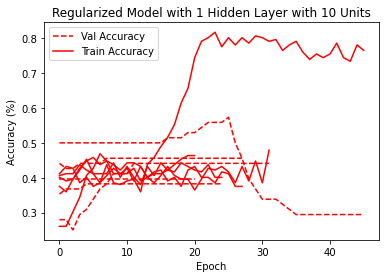

In [22]:
plt.figure
for i in range(len(val_acc_reg10)):
    plt.plot(val_acc_reg10[i], label='Val Accuracy', c='red', ls='dashed')
    plt.plot(train_acc_reg10[i], label='Train Accuracy', c='red', ls='solid')
    # plt.axhline(y=max(val_acc_unreg), c='green', ls='dashed')
    plt.title('Regularized Model with 1 Hidden Layer with 10 Units')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Epoch')
    if i ==0:
        plt.legend()
    print(f"Maximum Validation Accuracy reached: {max(val_acc_reg10[i])}")        
plt.show()

In [23]:
# Train with regularization
SEED = None
seedrd = set_seed(seed=SEED)

# Run the model multiple time to get the variation of the training/validation performance
N = 5 # traing the model N times
val_acc_reg20    = []
train_acc_reg20  = []
param_norm_reg20 = []

for i in range(N):
    SEED = None
    seedrd = set_seed(seed=SEED)
    X_test, y_test, X_train, y_train = shuffle_and_split_data(X_temp, y, seed=seedrd)
    # DataLoader with random seed
    g_seed = torch.Generator()
    g_seed.manual_seed(seedrd)

    test_data = TensorDataset(X_test.T, y_test)
    test_loader = DataLoader(test_data, batch_size=batch_size,
                            shuffle=False, num_workers=0,
                            worker_init_fn=seed_worker,
                            generator=g_seed,
                            )
    train_data = TensorDataset(X_train.T, y_train)
    train_loader = DataLoader(train_data,
                            batch_size=batch_size,
                            drop_last=True,
                            shuffle=True,
                            worker_init_fn=seed_worker,
                            generator=g_seed,
                            )

    args = {
        'epochs': 50,
        'lr': 1e-3,
        'momentum': 0.99,
        'device': device,
        'lambda1': 0.005,
        'lambda2': 0.005
    }
    # Train the model
    # plt.figure()

    hidden_units = 20
    model = Net('ReLU()', X_train.shape[0], [hidden_units], 3).to(device)  # single hidden layer
    val_acc, train_acc, param_norm, _ = early_stopping_main(args,
                                                            model,
                                                            train_loader,
                                                            test_loader,
                                                            reg_function1 = l1_reg,
                                                            reg_function2 = l2_reg)
    val_acc_reg20 += [val_acc]
    train_acc_reg20 += [train_acc]
    print(f"Finish training the Model {i + 1}")
    



Random seed 734 has been set.
Random seed 16829 has been set.


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\KeChen\AppData\Local\Temp/ipykernel_27640/4290504073.py:62: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(logits)


Early stopped on epoch: 21
Finish training the Model 1
Random seed 21860 has been set.


  0%|          | 0/50 [00:00<?, ?it/s]

Early stopped on epoch: 43
Finish training the Model 2
Random seed 52792 has been set.


  0%|          | 0/50 [00:00<?, ?it/s]

Early stopped on epoch: 49
Finish training the Model 3
Random seed 45600 has been set.


  0%|          | 0/50 [00:00<?, ?it/s]

Early stopped on epoch: 45
Finish training the Model 4
Random seed 43810 has been set.


  0%|          | 0/50 [00:00<?, ?it/s]

Early stopped on epoch: 41
Finish training the Model 5


Maximum Validation Accuracy reached: 0.4117647058823529
Maximum Validation Accuracy reached: 0.3382352941176471
Maximum Validation Accuracy reached: 0.3382352941176471
Maximum Validation Accuracy reached: 0.47058823529411764
Maximum Validation Accuracy reached: 0.5294117647058824


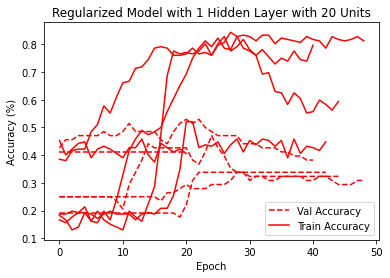

In [24]:
plt.figure
for i in range(len(val_acc_reg20)):
    plt.plot(val_acc_reg20[i], label='Val Accuracy', c='red', ls='dashed')
    plt.plot(train_acc_reg20[i], label='Train Accuracy', c='red', ls='solid')
    # plt.axhline(y=max(val_acc_unreg), c='green', ls='dashed')
    plt.title('Regularized Model with 1 Hidden Layer with 20 Units')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Epoch')
    if i ==0:
        plt.legend()
    print(f"Maximum Validation Accuracy reached: {max(val_acc_reg20[i])}")        
plt.show()

In [25]:
# Train with regularization
SEED = None
seedrd = set_seed(seed=SEED)

# Run the model multiple time to get the variation of the training/validation performance
N = 5 # traing the model N times
val_acc_reg40    = []
train_acc_reg40  = []
param_norm_reg40 = []

for i in range(N):
    SEED = None
    seedrd = set_seed(seed=SEED)
    X_test, y_test, X_train, y_train = shuffle_and_split_data(X_temp, y, seed=seedrd)
    # DataLoader with random seed
    g_seed = torch.Generator()
    g_seed.manual_seed(seedrd)

    test_data = TensorDataset(X_test.T, y_test)
    test_loader = DataLoader(test_data, batch_size=batch_size,
                            shuffle=False, num_workers=0,
                            worker_init_fn=seed_worker,
                            generator=g_seed,
                            )
    train_data = TensorDataset(X_train.T, y_train)
    train_loader = DataLoader(train_data,
                            batch_size=batch_size,
                            drop_last=True,
                            shuffle=True,
                            worker_init_fn=seed_worker,
                            generator=g_seed,
                            )

    args = {
        'epochs': 50,
        'lr': 1e-3,
        'momentum': 0.99,
        'device': device,
        'lambda1': 0.005,
        'lambda2': 0.005
    }
    # Train the model
    # plt.figure()

    hidden_units = 40
    model = Net('ReLU()', X_train.shape[0], [hidden_units], 3).to(device)  # single hidden layer
    val_acc, train_acc, param_norm, _ = early_stopping_main(args,
                                                            model,
                                                            train_loader,
                                                            test_loader,
                                                            reg_function1 = l1_reg,
                                                            reg_function2 = l2_reg)
    val_acc_reg40 += [val_acc]
    train_acc_reg40 += [train_acc]
    print(f"Finish training the Model {i + 1}")
    



Random seed 53612 has been set.
Random seed 44360 has been set.


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\KeChen\AppData\Local\Temp/ipykernel_27640/4290504073.py:62: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(logits)


Finish training the Model 1
Random seed 13800 has been set.


  0%|          | 0/50 [00:00<?, ?it/s]

Early stopped on epoch: 21
Finish training the Model 2
Random seed 1107 has been set.


  0%|          | 0/50 [00:00<?, ?it/s]

Early stopped on epoch: 21
Finish training the Model 3
Random seed 27536 has been set.


  0%|          | 0/50 [00:00<?, ?it/s]

Early stopped on epoch: 21
Finish training the Model 4
Random seed 49101 has been set.


  0%|          | 0/50 [00:00<?, ?it/s]

Early stopped on epoch: 21
Finish training the Model 5


Maximum Validation Accuracy reached: 0.5735294117647058
Maximum Validation Accuracy reached: 0.47058823529411764
Maximum Validation Accuracy reached: 0.39705882352941174
Maximum Validation Accuracy reached: 0.38235294117647056
Maximum Validation Accuracy reached: 0.4264705882352941


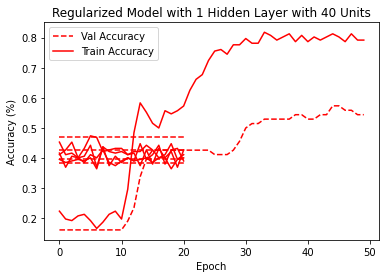

In [26]:
plt.figure
for i in range(len(val_acc_reg40)):
    plt.plot(val_acc_reg40[i], label='Val Accuracy', c='red', ls='dashed')
    plt.plot(train_acc_reg40[i], label='Train Accuracy', c='red', ls='solid')
    # plt.axhline(y=max(val_acc_unreg), c='green', ls='dashed')
    plt.title('Regularized Model with 1 Hidden Layer with 40 Units')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Epoch')
    if i ==0:
        plt.legend()
    print(f"Maximum Validation Accuracy reached: {max(val_acc_reg40[i])}")        
plt.show()



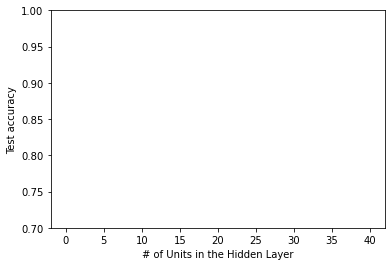

In [27]:
val_acc_unreg_avg = np.array([max(val_acc) for val_acc in val_acc_reg])
val_acc_reg10_avg = np.array([max(val_acc) for val_acc in val_acc_reg10])
val_acc_reg20_avg = np.array([max(val_acc) for val_acc in val_acc_reg20])
val_acc_reg40_avg = np.array([max(val_acc) for val_acc in val_acc_reg40])
hidden_units = [0, 10, 20, 40]
val_acc = np.array([val_acc_unreg_avg, val_acc_reg10_avg, val_acc_reg20_avg, val_acc_reg40_avg])

plt.figure()
plt.scatter(hidden_units, np.mean(val_acc, axis = 1))
for i in range(4):
    plt.plot([hidden_units[i], hidden_units[i]], [np.mean(val_acc[i,:])- np.std(val_acc[i,:]), np.mean(val_acc[i,:])+ np.std(val_acc[i,:])])
    plt.xlabel('# of Units in the Hidden Layer')
    plt.ylabel('Test accuracy')
    plt.ylim([0.7, 1])
plt.show()



With two hidden layers

Random seed 34025 has been set.
Random seed 24981 has been set.


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\KeChen\AppData\Local\Temp/ipykernel_27640/4290504073.py:62: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(logits)


Early stopped on epoch: 21
Finish training the Model 1
Random seed 24508 has been set.


  0%|          | 0/50 [00:00<?, ?it/s]

Early stopped on epoch: 28
Finish training the Model 2
Random seed 48823 has been set.


  0%|          | 0/50 [00:00<?, ?it/s]

Early stopped on epoch: 21
Finish training the Model 3
Random seed 24705 has been set.


  0%|          | 0/50 [00:00<?, ?it/s]

Early stopped on epoch: 21
Finish training the Model 4
Random seed 17779 has been set.


  0%|          | 0/50 [00:00<?, ?it/s]

Early stopped on epoch: 33
Finish training the Model 5
Maximum Validation Accuracy reached: 0.4117647058823529
Maximum Validation Accuracy reached: 0.4852941176470588
Maximum Validation Accuracy reached: 0.35294117647058826
Maximum Validation Accuracy reached: 0.3235294117647059
Maximum Validation Accuracy reached: 0.35294117647058826


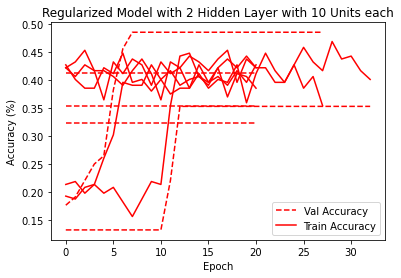

In [28]:
# # Train with regularization; 2 hidden layers, each with 10 units

SEED = None
seedrd = set_seed(seed=SEED)

# Run the model multiple time to get the variation of the training/validation performance
N = 5 # traing the model N times
val_acc_reg10_layers   = []
train_acc_reg10_layers  = []
param_norm_reg10_layers = []
hidden_units = [10, 10]

for i in range(N):
    SEED = None
    seedrd = set_seed(seed=SEED)
    X_test, y_test, X_train, y_train = shuffle_and_split_data(X_temp, y, seed=seedrd)
    # DataLoader with random seed
    g_seed = torch.Generator()
    g_seed.manual_seed(seedrd)

    test_data = TensorDataset(X_test.T, y_test)
    test_loader = DataLoader(test_data, batch_size=batch_size,
                            shuffle=False, num_workers=0,
                            worker_init_fn=seed_worker,
                            generator=g_seed,
                            )
    train_data = TensorDataset(X_train.T, y_train)
    train_loader = DataLoader(train_data,
                            batch_size=batch_size,
                            drop_last=True,
                            shuffle=True,
                            worker_init_fn=seed_worker,
                            generator=g_seed,
                            )

    args = {
        'epochs': 50,
        'lr': 1e-3,
        'momentum': 0.99,
        'device': device,
        'lambda1': 0.005,
        'lambda2': 0.005
    }
    # Train the model
    # plt.figure()

    model = Net('ReLU()', X_train.shape[0], hidden_units, 3).to(device)  # single hidden layer
    val_acc, train_acc, param_norm, _ = early_stopping_main(args,
                                                            model,
                                                            train_loader,
                                                            test_loader,
                                                            reg_function1 = l1_reg,
                                                            reg_function2 = l2_reg)
    val_acc_reg10_layers  += [val_acc]
    train_acc_reg10_layers += [train_acc]
    print(f"Finish training the Model {i + 1}")
    
plt.figure
for i in range(len(val_acc_reg10_layers)):
    plt.plot(val_acc_reg10_layers[i], label='Val Accuracy', c='red', ls='dashed')
    plt.plot(train_acc_reg10_layers[i], label='Train Accuracy', c='red', ls='solid')
    # plt.axhline(y=max(val_acc_unreg), c='green', ls='dashed')
    plt.title('Regularized Model with 2 Hidden Layer with 10 Units each')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Epoch')
    if i ==0:
        plt.legend()
    print(f"Maximum Validation Accuracy reached: {max(val_acc_reg10_layers[i])}")        
plt.show()


Random seed 61705 has been set.
Random seed 5886 has been set.


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\KeChen\AppData\Local\Temp/ipykernel_27640/4290504073.py:62: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(logits)


Early stopped on epoch: 21
Finish training the Model 1
Random seed 28703 has been set.


  0%|          | 0/50 [00:00<?, ?it/s]

Early stopped on epoch: 30
Finish training the Model 2
Random seed 53920 has been set.


  0%|          | 0/50 [00:00<?, ?it/s]

Early stopped on epoch: 21
Finish training the Model 3
Random seed 8630 has been set.


  0%|          | 0/50 [00:00<?, ?it/s]

Early stopped on epoch: 21
Finish training the Model 4
Random seed 43133 has been set.


  0%|          | 0/50 [00:00<?, ?it/s]

Early stopped on epoch: 21
Finish training the Model 5
Maximum Validation Accuracy reached: 0.38235294117647056
Maximum Validation Accuracy reached: 0.35294117647058826
Maximum Validation Accuracy reached: 0.5
Maximum Validation Accuracy reached: 0.45588235294117646
Maximum Validation Accuracy reached: 0.4117647058823529


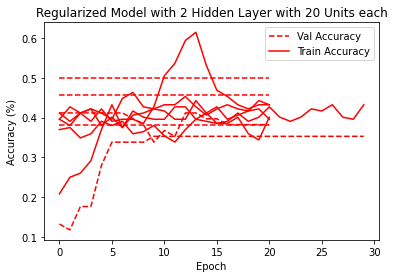

In [29]:
# Train with regularization; 2 hidden layers, each with 20 units
SEED = None
seedrd = set_seed(seed=SEED)

# Run the model multiple time to get the variation of the training/validation performance
N = 5 # traing the model N times
val_acc_reg20_layers   = []
train_acc_reg20_layers  = []
param_norm_reg20_layers = []
hidden_units = [20, 20]

for i in range(N):
    SEED = None
    seedrd = set_seed(seed=SEED)
    X_test, y_test, X_train, y_train = shuffle_and_split_data(X_temp, y, seed=seedrd)
    # DataLoader with random seed
    g_seed = torch.Generator()
    g_seed.manual_seed(seedrd)

    test_data = TensorDataset(X_test.T, y_test)
    test_loader = DataLoader(test_data, batch_size=batch_size,
                            shuffle=False, num_workers=0,
                            worker_init_fn=seed_worker,
                            generator=g_seed,
                            )
    train_data = TensorDataset(X_train.T, y_train)
    train_loader = DataLoader(train_data,
                            batch_size=batch_size,
                            drop_last=True,
                            shuffle=True,
                            worker_init_fn=seed_worker,
                            generator=g_seed,
                            )

    args = {
        'epochs': 50,
        'lr': 1e-3,
        'momentum': 0.99,
        'device': device,
        'lambda1': 0.005,
        'lambda2': 0.005
    }
    # Train the model
    # plt.figure()

    model = Net('ReLU()', X_train.shape[0], hidden_units, 3).to(device)  # single hidden layer
    val_acc, train_acc, param_norm, _ = early_stopping_main(args,
                                                            model,
                                                            train_loader,
                                                            test_loader,
                                                            reg_function1 = l1_reg,
                                                            reg_function2 = l2_reg)
    val_acc_reg20_layers  += [val_acc]
    train_acc_reg20_layers += [train_acc]
    print(f"Finish training the Model {i + 1}")
    
plt.figure
for i in range(len(val_acc_reg20_layers)):
    plt.plot(val_acc_reg20_layers[i], label='Val Accuracy', c='red', ls='dashed')
    plt.plot(train_acc_reg20_layers[i], label='Train Accuracy', c='red', ls='solid')
    # plt.axhline(y=max(val_acc_unreg), c='green', ls='dashed')
    plt.title('Regularized Model with 2 Hidden Layer with 20 Units each')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Epoch')
    if i ==0:
        plt.legend()
    print(f"Maximum Validation Accuracy reached: {max(val_acc_reg20_layers[i])}")        
plt.show()


Random seed 62373 has been set.
Random seed 60421 has been set.


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\KeChen\AppData\Local\Temp/ipykernel_27640/4290504073.py:62: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(logits)


Early stopped on epoch: 31
Finish training the Model 1
Random seed 38576 has been set.


  0%|          | 0/50 [00:00<?, ?it/s]

Early stopped on epoch: 23
Finish training the Model 2
Random seed 33362 has been set.


  0%|          | 0/50 [00:00<?, ?it/s]

Early stopped on epoch: 21
Finish training the Model 3
Random seed 28176 has been set.


  0%|          | 0/50 [00:00<?, ?it/s]

Finish training the Model 4
Random seed 48604 has been set.


  0%|          | 0/50 [00:00<?, ?it/s]

Early stopped on epoch: 31
Finish training the Model 5
Maximum Validation Accuracy reached: 0.3235294117647059
Maximum Validation Accuracy reached: 0.47058823529411764
Maximum Validation Accuracy reached: 0.4411764705882353
Maximum Validation Accuracy reached: 0.4852941176470588
Maximum Validation Accuracy reached: 0.35294117647058826


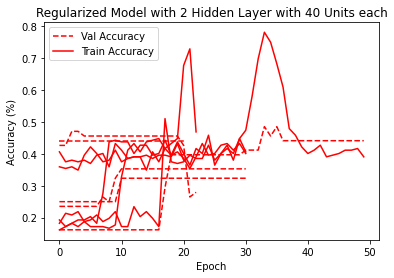

In [30]:
# Train with regularization; 2 hidden layers, each with 40 units
SEED = None
seedrd = set_seed(seed=SEED)

# Run the model multiple time to get the variation of the training/validation performance
N = 5 # traing the model N times
val_acc_reg40_layers   = []
train_acc_reg40_layers  = []
param_norm_reg40_layers = []
hidden_units = [40, 40]

for i in range(N):
    SEED = None
    seedrd = set_seed(seed=SEED)
    X_test, y_test, X_train, y_train = shuffle_and_split_data(X_temp, y, seed=seedrd)
    # DataLoader with random seed
    g_seed = torch.Generator()
    g_seed.manual_seed(seedrd)

    test_data = TensorDataset(X_test.T, y_test)
    test_loader = DataLoader(test_data, batch_size=batch_size,
                            shuffle=False, num_workers=0,
                            worker_init_fn=seed_worker,
                            generator=g_seed,
                            )
    train_data = TensorDataset(X_train.T, y_train)
    train_loader = DataLoader(train_data,
                            batch_size=batch_size,
                            drop_last=True,
                            shuffle=True,
                            worker_init_fn=seed_worker,
                            generator=g_seed,
                            )

    args = {
        'epochs': 50,
        'lr': 1e-3,
        'momentum': 0.99,
        'device': device,
        'lambda1': 0.005,
        'lambda2': 0.005
    }
    # Train the model
    # plt.figure()

    model = Net('ReLU()', X_train.shape[0], hidden_units, 3).to(device)  # single hidden layer
    val_acc, train_acc, param_norm, _ = early_stopping_main(args,
                                                            model,
                                                            train_loader,
                                                            test_loader,
                                                            reg_function1 = l1_reg,
                                                            reg_function2 = l2_reg)
    val_acc_reg40_layers  += [val_acc]
    train_acc_reg40_layers += [train_acc]
    print(f"Finish training the Model {i + 1}")
    
plt.figure
for i in range(len(val_acc_reg40_layers)):
    plt.plot(val_acc_reg40_layers[i], label='Val Accuracy', c='red', ls='dashed')
    plt.plot(train_acc_reg40_layers[i], label='Train Accuracy', c='red', ls='solid')
    # plt.axhline(y=max(val_acc_unreg), c='green', ls='dashed')
    plt.title('Regularized Model with 2 Hidden Layer with 40 Units each')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Epoch')
    if i ==0:
        plt.legend()
    print(f"Maximum Validation Accuracy reached: {max(val_acc_reg40_layers[i])}")        
plt.show()


Plot the classification accuracy trained with MLP with 0, 1, and 2 hidden layer

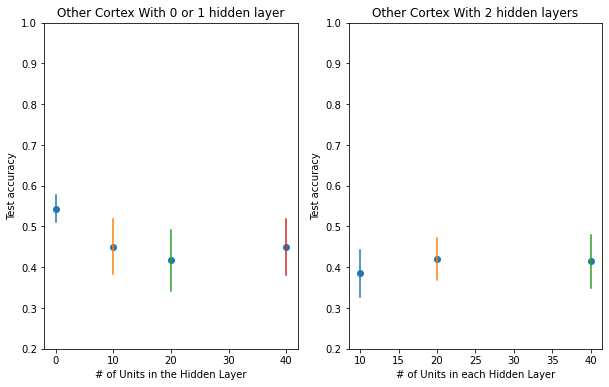

In [31]:
val_acc_reg10_layer_avg = np.array([max(val_acc) for val_acc in val_acc_reg10_layers])
val_acc_reg20_layer_avg = np.array([max(val_acc) for val_acc in val_acc_reg20_layers])
val_acc_reg40_layer_avg = np.array([max(val_acc) for val_acc in val_acc_reg40_layers])
hidden_units = [0, 10, 20, 40]
val_acc = np.array([val_acc_unreg_avg, val_acc_reg10_avg, val_acc_reg20_avg, val_acc_reg40_avg])
val_acc_layer = np.array([val_acc_reg10_layer_avg, val_acc_reg20_layer_avg, val_acc_reg40_layer_avg, 
                    ])

plt.figure(figsize= (10, 6))
plt.subplot(1, 2, 1)
plt.scatter(hidden_units, np.mean(val_acc, axis = 1))
for i in range(4):
    plt.plot([hidden_units[i], hidden_units[i]], [np.mean(val_acc[i,:])- np.std(val_acc[i,:]), np.mean(val_acc[i,:])+ np.std(val_acc[i,:])])
plt.xlabel('# of Units in the Hidden Layer')
plt.ylabel('Test accuracy')
plt.ylim([0.2, 1])
plt.title('Other Cortex With 0 or 1 hidden layer')


plt.subplot(1, 2, 2)
plt.scatter(hidden_units[1:], np.mean(val_acc_layer, axis = 1))
for i in range(3):
    plt.plot([hidden_units[i+1], hidden_units[i+1]], [np.mean(val_acc_layer[i,:])- np.std(val_acc_layer[i,:]), np.mean(val_acc_layer[i,:])+ np.std(val_acc_layer[i,:])])
plt.xlabel('# of Units in each Hidden Layer')
plt.ylabel('Test accuracy')
plt.ylim([0.2, 1])
plt.title('Other Cortex With 2 hidden layers')
plt.show()